In [ ]:
#| default_exp workflow

In [ ]:
#| export

from chewc.structs import *
from chewc.pheno import *
from chewc.select import *
from chewc.cross import *
import jax
import jax.numpy as jnp
from jax import lax
from functools import partial
from typing import Tuple

print("This document represents a template for a simple breeding simulation for selection. It is meant to be a guide to developing my complex or flexible breeding designs.")


@partial(jax.jit, static_argnames=("n_select", "n_offspring", "max_crossovers"))
def selection_step(
    carry: BreedingState,
    _, # Placeholder for lax.scan's iteration number
    trait: Trait,
    genetic_map: GeneticMap,
    heritabilities: jnp.ndarray,
    n_select: int,
    n_offspring: int,
    max_crossovers: int
) -> Tuple[BreedingState, jnp.ndarray]:
    """
    Executes one full cycle of selection and breeding.
    This function is designed to be the body of a lax.scan loop.
    """
    key, pheno_key, mating_key, cross_key = jax.random.split(carry.key, 4)
    current_pop = carry.population

    # 1. Evaluate the population
    phenotypes, tbvs = calculate_phenotypes(
        key=pheno_key, population=current_pop, trait=trait, heritability=heritabilities
    )
    mean_tbv = jnp.mean(tbvs[:, 0]) # Track genetic gain for trait 1

    # 2. Select top parents
    selected_parents = select_top_k(current_pop, phenotypes[:, 0], k=n_select)

    # 3. Generate a random mating plan
    pairings = random_mating(mating_key, n_parents=n_select, n_crosses=n_offspring)
    mother_indices, father_indices = pairings[:, 0], pairings[:, 1]

    # 4. Create the next generation
    mothers_geno = selected_parents.geno[mother_indices]
    fathers_geno = selected_parents.geno[father_indices]
    mothers_ibd = selected_parents.ibd[mother_indices]
    fathers_ibd = selected_parents.ibd[father_indices]

    # Vectorize the crossing operation over all pairs
    vmapped_cross = jax.vmap(
        cross_pair, in_axes=(0, 0, 0, 0, 0, None, None)
    )
    offspring_keys = jax.random.split(cross_key, n_offspring)
    offspring_geno, offspring_ibd = vmapped_cross(
        offspring_keys, mothers_geno, fathers_geno, mothers_ibd, fathers_ibd, genetic_map, max_crossovers
    )

    # 5. Form the new population and update the state
    new_generation = carry.generation + 1
    new_ids = jnp.arange(n_offspring, dtype=jnp.int32) + carry.next_id
    new_meta = jnp.stack(
        [
            new_ids,
            selected_parents.meta[mother_indices, 0],
            selected_parents.meta[father_indices, 0],
            jnp.full((n_offspring,), new_generation, dtype=jnp.int32),
        ],
        axis=-1,
    )
    new_population = Population(geno=offspring_geno, ibd=offspring_ibd, meta=new_meta)

    next_state = BreedingState(
        population=new_population,
        key=key,
        generation=new_generation,
        next_id=carry.next_id + n_offspring
    )

    # The scan function requires a `(carry, output)` return signature.
    # `carry` is the state for the next iteration.
    # `output` is the data we want to collect at each step.
    return next_state, mean_tbv


def run_simulation_cycles(
    initial_state: BreedingState,
    trait: Trait,
    genetic_map: GeneticMap,
    heritabilities: jnp.ndarray,
    n_cycles: int,
    n_select: int,
    n_offspring: int,
    max_crossovers: int
):
    """
    Runs the entire multi-cycle simulation using lax.scan for maximum performance.
    """
    # `lax.scan` requires the body function to be a callable that takes
    # (carry, x) and returns (new_carry, y). We use a lambda to fix the
    # static arguments and data that doesn't change over the loop.
    scan_fn = lambda carry, _: selection_step(
        carry,
        _,
        trait=trait,
        genetic_map=genetic_map,
        heritabilities=heritabilities,
        n_select=n_select,
        n_offspring=n_offspring,
        max_crossovers=max_crossovers
    )

    # Run the scan. The `None` is a placeholder for the `xs` array,
    # as we only care about the number of iterations (`length`).
    final_state, tbv_history = lax.scan(
        scan_fn, initial_state, None, length=n_cycles
    )

    return final_state, tbv_history


# ----------------------------------------------------
# Main execution script
# ----------------------------------------------------

if __name__ == "__main__":
    print("--- Running 10-Cycle Phenotypic Selection Experiment ---")

    # --- Simulation Parameters ---
    N_FOUNDERS = 100
    N_SELECT = 20
    N_OFFSPRING = 200 # Population size is kept constant after the first cycle
    N_CYCLES = 20

    N_CHR, N_LOCI = 5, 1000
    MAX_CROSSOVERS = 10
    SEED = 42

    key = jax.random.PRNGKey(SEED)

    # --- Setup ---
    key, pop_key, trait_key = jax.random.split(key, 3)
    print("\nStep 1: Initializing founder population...")
    founder_pop, genetic_map = quick_haplo(
        key=pop_key, n_ind=N_FOUNDERS, n_chr=N_CHR, seg_sites=N_LOCI,
        inbred=False, chr_length=1.0
    )

    print("Step 2: Initializing trait architecture...")
    trait_architecture = add_trait(
        key=trait_key, founder_pop=founder_pop, n_qtl_per_chr=50,
        mean=jnp.array([0.0]), var_a=jnp.array([1.0]), var_d=jnp.array([0.0]),
        sigma=jnp.array([[10.0]])
    )
    heritabilities = jnp.array([0.9])

    # --- Initial State ---
    initial_state = BreedingState(
        population=founder_pop,
        key=key,
        generation=0,
        next_id=N_FOUNDERS # Next available individual ID
    )
    print(f"  - Founder population size: {N_FOUNDERS}")
    print(f"  - Selection: Top {N_SELECT} individuals")
    print(f"  - Offspring per cycle: {N_OFFSPRING}")

    # --- Burn-in Cycle ---
    print("\nStep 3: Running burn-in cycle to stabilize population size...")
    
    # Calculate initial TBV for generation 0
    key, initial_pheno_key = jax.random.split(initial_state.key)
    _, initial_tbvs = calculate_phenotypes(
        key=initial_pheno_key, population=initial_state.population,
        trait=trait_architecture, heritability=heritabilities
    )
    initial_mean_tbv = jnp.mean(initial_tbvs[:, 0])

    # Run the first selection step manually
    burn_in_state, first_cycle_tbv = selection_step(
        carry=initial_state,
        _ = 0, # Placeholder for iteration number
        trait=trait_architecture,
        genetic_map=genetic_map,
        heritabilities=heritabilities,
        n_select=N_SELECT,
        n_offspring=N_OFFSPRING,
        max_crossovers=MAX_CROSSOVERS,
    )

    # --- Run Simulation ---
    print(f"\nStep 4: Running remaining {N_CYCLES - 1} selection cycles (JIT compiling...)\n")
    
    # Run the rest of the simulation using lax.scan
    final_state, tbv_history = run_simulation_cycles(
        initial_state=burn_in_state,
        trait=trait_architecture,
        genetic_map=genetic_map,
        heritabilities=heritabilities,
        n_cycles=N_CYCLES - 1,
        n_select=N_SELECT,
        n_offspring=N_OFFSPRING,
        max_crossovers=MAX_CROSSOVERS,
    )

    # --- Report Results ---
    print("--- Results ---")
    print(f"Generation 00 Mean TBV: {initial_mean_tbv:.3f}")
    print(f"Generation 01 Mean TBV: {first_cycle_tbv:.3f} (Gain: {first_cycle_tbv - initial_mean_tbv:+.3f})")

    # Combine initial TBV, burn-in TBV, and the history from the scan
    full_history = jnp.concatenate([jnp.array([initial_mean_tbv, first_cycle_tbv]), tbv_history])
    for i, tbv in enumerate(tbv_history, 2):
        gain = tbv - full_history[i-1]
        print(f"Generation {i:02d} Mean TBV: {tbv:.3f} (Gain: {gain:+.3f})")

    total_gain = tbv_history[-1] - initial_mean_tbv
    print(f"\n--- Total Genetic Gain over {N_CYCLES} generations: {total_gain:+.3f} ---")

This document represents a template for a simple breeding simulation for selection. It is meant to be a guide to developing my complex or flexible breeding designs.
--- Running 10-Cycle Phenotypic Selection Experiment ---

Step 1: Initializing founder population...
Step 2: Initializing trait architecture...
  - Founder population size: 100
  - Selection: Top 20 individuals
  - Offspring per cycle: 200

Step 3: Running burn-in cycle to stabilize population size...

Step 4: Running remaining 19 selection cycles (JIT compiling...)

--- Results ---
Generation 00 Mean TBV: 0.816
Generation 01 Mean TBV: 0.816 (Gain: +0.000)
Generation 02 Mean TBV: 2.206 (Gain: +1.390)
Generation 03 Mean TBV: 3.775 (Gain: +1.569)
Generation 04 Mean TBV: 5.289 (Gain: +1.514)
Generation 05 Mean TBV: 6.590 (Gain: +1.301)
Generation 06 Mean TBV: 7.983 (Gain: +1.394)
Generation 07 Mean TBV: 9.112 (Gain: +1.129)
Generation 08 Mean TBV: 10.077 (Gain: +0.965)
Generation 09 Mean TBV: 10.777 (Gain: +0.700)
Generation 1

In [ ]:
import jax
import jax.numpy as jnp
import chex
import numpy as np
from flax import struct
from functools import partial
from typing import Optional, Tuple, Union, Any
from gymnax.environments import environment, spaces
from brax import envs
from brax.envs.wrappers.training import EpisodeWrapper, AutoResetWrapper
import navix as nx


class GymnaxWrapper(object):
    """Base class for Gymnax wrappers."""

    def __init__(self, env):
        self._env = env

    # provide proxy access to regular attributes of wrapped object
    def __getattr__(self, name):
        return getattr(self._env, name)


class FlattenObservationWrapper(GymnaxWrapper):
    """Flatten the observations of the environment."""

    def __init__(self, env: environment.Environment):
        super().__init__(env)

    def observation_space(self, params) -> spaces.Box:
        assert isinstance(
            self._env.observation_space(params), spaces.Box
        ), "Only Box spaces are supported for now."
        return spaces.Box(
            low=self._env.observation_space(params).low,
            high=self._env.observation_space(params).high,
            shape=(np.prod(self._env.observation_space(params).shape),),
            dtype=self._env.observation_space(params).dtype,
        )

    @partial(jax.jit, static_argnums=(0,))
    def reset(
        self, key: chex.PRNGKey, params: Optional[environment.EnvParams] = None
    ) -> Tuple[chex.Array, environment.EnvState]:
        obs, state = self._env.reset(key, params)
        obs = jnp.reshape(obs, (-1,))
        return obs, state

    @partial(jax.jit, static_argnums=(0,))
    def step(
        self,
        key: chex.PRNGKey,
        state: environment.EnvState,
        action: Union[int, float],
        params: Optional[environment.EnvParams] = None,
    ) -> Tuple[chex.Array, environment.EnvState, float, bool, dict]:
        obs, state, reward, done, info = self._env.step(key, state, action, params)
        obs = jnp.reshape(obs, (-1,))
        return obs, state, reward, done, info


@struct.dataclass
class LogEnvState:
    env_state: environment.EnvState
    episode_returns: float
    episode_lengths: int
    returned_episode_returns: float
    returned_episode_lengths: int
    timestep: int


class LogWrapper(GymnaxWrapper):
    """Log the episode returns and lengths."""

    def __init__(self, env: environment.Environment):
        super().__init__(env)

    @partial(jax.jit, static_argnums=(0,))
    def reset(
        self, key: chex.PRNGKey, params: Optional[environment.EnvParams] = None
    ) -> Tuple[chex.Array, environment.EnvState]:
        obs, env_state = self._env.reset(key, params)
        state = LogEnvState(env_state, 0, 0, 0, 0, 0)
        return obs, state

    @partial(jax.jit, static_argnums=(0,))
    def step(
        self,
        key: chex.PRNGKey,
        state: environment.EnvState,
        action: Union[int, float],
        params: Optional[environment.EnvParams] = None,
    ) -> Tuple[chex.Array, environment.EnvState, float, bool, dict]:
        obs, env_state, reward, done, info = self._env.step(
            key, state.env_state, action, params
        )
        new_episode_return = state.episode_returns + reward
        new_episode_length = state.episode_lengths + 1
        state = LogEnvState(
            env_state=env_state,
            episode_returns=new_episode_return * (1 - done),
            episode_lengths=new_episode_length * (1 - done),
            returned_episode_returns=state.returned_episode_returns * (1 - done)
            + new_episode_return * done,
            returned_episode_lengths=state.returned_episode_lengths * (1 - done)
            + new_episode_length * done,
            timestep=state.timestep + 1,
        )
        info["returned_episode_returns"] = state.returned_episode_returns
        info["returned_episode_lengths"] = state.returned_episode_lengths
        info["timestep"] = state.timestep
        info["returned_episode"] = done
        return obs, state, reward, done, info


class BraxGymnaxWrapper:
    def __init__(self, env_name, backend="positional"):
        env = envs.get_environment(env_name=env_name, backend=backend)
        env = EpisodeWrapper(env, episode_length=1000, action_repeat=1)
        env = AutoResetWrapper(env)
        self._env = env
        self.action_size = env.action_size
        self.observation_size = (env.observation_size,)

    def reset(self, key, params=None):
        state = self._env.reset(key)
        return state.obs, state

    def step(self, key, state, action, params=None):
        next_state = self._env.step(state, action)
        return next_state.obs, next_state, next_state.reward, next_state.done > 0.5, {}

    def observation_space(self, params):
        return spaces.Box(
            low=-jnp.inf,
            high=jnp.inf,
            shape=(self._env.observation_size,),
        )

    def action_space(self, params):
        return spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(self._env.action_size,),
        )

class NavixGymnaxWrapper:
    def __init__(self, env_name):
        self._env = nx.make(env_name)

    def reset(self, key, params=None):
        timestep = self._env.reset(key)
        return timestep.observation, timestep

    def step(self, key, state, action, params=None):
        timestep = self._env.step(state, action)
        return timestep.observation, timestep, timestep.reward, timestep.is_done(), {}

    def observation_space(self, params):
        return spaces.Box(
            low=self._env.observation_space.minimum,
            high=self._env.observation_space.maximum,
            shape=(np.prod(self._env.observation_space.shape),),
            dtype=self._env.observation_space.dtype,
        )

    def action_space(self, params):
        return spaces.Discrete(
            num_categories=self._env.action_space.maximum.item() + 1,
        )


class ClipAction(GymnaxWrapper):
    def __init__(self, env, low=-1.0, high=1.0):
        super().__init__(env)
        self.low = low
        self.high = high

    def step(self, key, state, action, params=None):
        """TODO: In theory the below line should be the way to do this."""
        # action = jnp.clip(action, self.env.action_space.low, self.env.action_space.high)
        action = jnp.clip(action, self.low, self.high)
        return self._env.step(key, state, action, params)


class TransformObservation(GymnaxWrapper):
    def __init__(self, env, transform_obs):
        super().__init__(env)
        self.transform_obs = transform_obs

    def reset(self, key, params=None):
        obs, state = self._env.reset(key, params)
        return self.transform_obs(obs), state

    def step(self, key, state, action, params=None):
        obs, state, reward, done, info = self._env.step(key, state, action, params)
        return self.transform_obs(obs), state, reward, done, info


class TransformReward(GymnaxWrapper):
    def __init__(self, env, transform_reward):
        super().__init__(env)
        self.transform_reward = transform_reward

    def step(self, key, state, action, params=None):
        obs, state, reward, done, info = self._env.step(key, state, action, params)
        return obs, state, self.transform_reward(reward), done, info


class VecEnv(GymnaxWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.reset = jax.vmap(self._env.reset, in_axes=(0, None))
        self.step = jax.vmap(self._env.step, in_axes=(0, 0, 0, None))


@struct.dataclass
class NormalizeVecObsEnvState:
    mean: jnp.ndarray
    var: jnp.ndarray
    count: float
    env_state: environment.EnvState


class NormalizeVecObservation(GymnaxWrapper):
    def __init__(self, env):
        super().__init__(env)

    def reset(self, key, params=None):
        obs, state = self._env.reset(key, params)
        state = NormalizeVecObsEnvState(
            mean=jnp.zeros_like(obs),
            var=jnp.ones_like(obs),
            count=1e-4,
            env_state=state,
        )
        batch_mean = jnp.mean(obs, axis=0)
        batch_var = jnp.var(obs, axis=0)
        batch_count = obs.shape[0]

        delta = batch_mean - state.mean
        tot_count = state.count + batch_count

        new_mean = state.mean + delta * batch_count / tot_count
        m_a = state.var * state.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + jnp.square(delta) * state.count * batch_count / tot_count
        new_var = M2 / tot_count
        new_count = tot_count

        state = NormalizeVecObsEnvState(
            mean=new_mean,
            var=new_var,
            count=new_count,
            env_state=state.env_state,
        )

        return (obs - state.mean) / jnp.sqrt(state.var + 1e-8), state

    def step(self, key, state, action, params=None):
        obs, env_state, reward, done, info = self._env.step(
            key, state.env_state, action, params
        )

        batch_mean = jnp.mean(obs, axis=0)
        batch_var = jnp.var(obs, axis=0)
        batch_count = obs.shape[0]

        delta = batch_mean - state.mean
        tot_count = state.count + batch_count

        new_mean = state.mean + delta * batch_count / tot_count
        m_a = state.var * state.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + jnp.square(delta) * state.count * batch_count / tot_count
        new_var = M2 / tot_count
        new_count = tot_count

        state = NormalizeVecObsEnvState(
            mean=new_mean,
            var=new_var,
            count=new_count,
            env_state=env_state,
        )
        return (
            (obs - state.mean) / jnp.sqrt(state.var + 1e-8),
            state,
            reward,
            done,
            info,
        )


@struct.dataclass
class NormalizeVecRewEnvState:
    mean: jnp.ndarray
    var: jnp.ndarray
    count: float
    return_val: float
    env_state: environment.EnvState


class NormalizeVecReward(GymnaxWrapper):
    def __init__(self, env, gamma):
        super().__init__(env)
        self.gamma = gamma

    def reset(self, key, params=None):
        obs, state = self._env.reset(key, params)
        batch_count = obs.shape[0]
        state = NormalizeVecRewEnvState(
            mean=0.0,
            var=1.0,
            count=1e-4,
            return_val=jnp.zeros((batch_count,)),
            env_state=state,
        )
        return obs, state

    def step(self, key, state, action, params=None):
        obs, env_state, reward, done, info = self._env.step(
            key, state.env_state, action, params
        )
        return_val = state.return_val * self.gamma * (1 - done) + reward

        batch_mean = jnp.mean(return_val, axis=0)
        batch_var = jnp.var(return_val, axis=0)
        batch_count = obs.shape[0]

        delta = batch_mean - state.mean
        tot_count = state.count + batch_count

        new_mean = state.mean + delta * batch_count / tot_count
        m_a = state.var * state.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + jnp.square(delta) * state.count * batch_count / tot_count
        new_var = M2 / tot_count
        new_count = tot_count

        state = NormalizeVecRewEnvState(
            mean=new_mean,
            var=new_var,
            count=new_count,
            return_val=return_val,
            env_state=env_state,
        )
        return obs, state, reward / jnp.sqrt(state.var + 1e-8), done, info

/home/glect/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'


In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple
from flax.training.train_state import TrainState
import distrax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper
# from wrappers import (
#     VecEnv,
#     NormalizeVecObservation,
#     NormalizeVecReward,
#     ClipAction,
# )
from chewc.gym import StoaEnv

#| export
import jax
import jax.numpy as jnp
from gymnax.environments import environment, spaces
from typing import Tuple, Optional
from functools import partial
from jax.tree_util import tree_map

# Assuming the 'chewc' library files are in the path
from chewc.structs import Population, BreedingState, Trait, GeneticMap, quick_haplo, add_trait
from chewc.pheno import calculate_phenotypes
from chewc.cross import random_mating, cross_pair

class StoaEnv(environment.Environment):
    """
    A Gymnax environment for the ChewC breeding simulation.

    The agent's goal is to maximize the genetic gain of the population
    over a fixed number of generations by choosing the selection intensity at each step.
    """

    def __init__(self, n_founders=100, n_pop_size=200, n_chr=5, n_loci=1000, n_qtl_per_chr=50, total_gen=20, max_crossovers=10):
        super().__init__()
        self.n_founders = n_founders
        self.n_pop_size = n_pop_size
        self.total_gen = total_gen
        self.max_crossovers = max_crossovers
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.n_qtl_per_chr = n_qtl_per_chr

        key = jax.random.PRNGKey(42)
        pop_key, trait_key = jax.random.split(key)

        # Founder pop is created once and reused for every reset
        self.founder_pop, self.genetic_map = quick_haplo(
            key=pop_key, n_ind=self.n_founders, n_chr=self.n_chr, seg_sites=self.n_loci
        )

        self.trait_architecture = add_trait(
            key=trait_key,
            founder_pop=self.founder_pop,
            n_qtl_per_chr=self.n_qtl_per_chr,
            mean=jnp.array([100.0]),
            var_a=jnp.array([10.0]),
            var_d=jnp.array([0.0]),
            sigma=jnp.array([[1.0]])
        )
        self.heritabilities = jnp.array([0.5])

    @property
    def default_params(self):
        return {}

    def step_env(self, key: jax.Array, state: BreedingState, action: jax.Array, params) -> Tuple[jax.Array, BreedingState, float, bool, dict]:
        key, pheno_key, mating_key, cross_key = jax.random.split(key, 4)
        current_pop = state.population

        selection_proportion = (action[0] + 1) / 2 * (0.95 - 0.05) + 0.05

        phenotypes, _ = calculate_phenotypes(
            key=pheno_key,
            population=current_pop,
            trait=self.trait_architecture,
            heritability=self.heritabilities
        )

        n_current_pop = current_pop.geno.shape[0]
        n_select = (n_current_pop * selection_proportion).astype(jnp.int32)
        n_select = jnp.maximum(2, n_select)

        sorted_indices = jnp.argsort(-phenotypes[:, 0].flatten())
        sorted_parent_pool = tree_map(lambda x: x[sorted_indices], current_pop)

        pairings = random_mating(mating_key, n_parents=n_select, n_crosses=self.n_pop_size)
        mother_indices, father_indices = pairings[:, 0], pairings[:, 1]

        mothers_geno = sorted_parent_pool.geno[mother_indices]
        fathers_geno = sorted_parent_pool.geno[father_indices]
        mothers_ibd = sorted_parent_pool.ibd[mother_indices]
        fathers_ibd = sorted_parent_pool.ibd[father_indices]

        vmapped_cross = jax.vmap(cross_pair, in_axes=(0, 0, 0, 0, 0, None, None))
        offspring_keys = jax.random.split(cross_key, self.n_pop_size)
        offspring_geno, offspring_ibd = vmapped_cross(
            offspring_keys, mothers_geno, fathers_geno, mothers_ibd, fathers_ibd, self.genetic_map, self.max_crossovers
        )

        new_generation = state.generation + 1
        new_ids = jnp.arange(self.n_pop_size, dtype=jnp.int32) + state.next_id
        new_meta = jnp.stack([
            new_ids,
            sorted_parent_pool.meta[mother_indices, 0],
            sorted_parent_pool.meta[father_indices, 0],
            jnp.full((self.n_pop_size,), new_generation, dtype=jnp.int32),
        ], axis=-1)

        new_population = Population(geno=offspring_geno, ibd=offspring_ibd, meta=new_meta)

        next_state = BreedingState(
            population=new_population, key=key, generation=new_generation, next_id=state.next_id + self.n_pop_size
        )

        done = next_state.generation >= self.total_gen

        def get_final_reward(final_state: BreedingState):
            reward_key, _ = jax.random.split(final_state.key)
            _, tbvs = calculate_phenotypes(
                reward_key, final_state.population, self.trait_architecture, self.heritabilities
            )
            return jnp.mean(tbvs[:, 0])

        reward = jax.lax.cond(done, get_final_reward, lambda s: 0.0, operand=next_state)

        obs = self._get_obs(next_state)
        return obs, next_state, reward, done, {}

    def reset_env(self, key: jax.Array, params) -> Tuple[jax.Array, BreedingState]:
        """
        Resets the environment. Includes a "burn-in" step to ensure the
        initial population size matches the ongoing population size, which is
        required for JAX's conditional logic in auto-resetting environments.
        """
        # Create a new state with the small founder population at generation 0
        burn_in_key, pheno_key, mating_key, cross_key = jax.random.split(key, 4)
        founder_state = BreedingState(
            population=self.founder_pop, key=burn_in_key, generation=0, next_id=self.n_founders
        )

        # --- Perform a single burn-in breeding step to reach `n_pop_size` ---
        phenotypes, _ = calculate_phenotypes(
            pheno_key, founder_state.population, self.trait_architecture, self.heritabilities
        )

        # Select top 50% of founders by default for the first cross
        n_select = jnp.maximum(2, self.n_founders // 2)
        sorted_indices = jnp.argsort(-phenotypes[:, 0].flatten())
        sorted_founders = tree_map(lambda x: x[sorted_indices], founder_state.population)

        pairings = random_mating(mating_key, n_parents=n_select, n_crosses=self.n_pop_size)
        mother_indices, father_indices = pairings[:, 0], pairings[:, 1]

        mothers_geno = sorted_founders.geno[mother_indices]
        fathers_geno = sorted_founders.geno[father_indices]
        mothers_ibd = sorted_founders.ibd[mother_indices]
        fathers_ibd = sorted_founders.ibd[father_indices]

        vmapped_cross = jax.vmap(cross_pair, in_axes=(0, 0, 0, 0, 0, None, None))
        offspring_keys = jax.random.split(cross_key, self.n_pop_size)
        offspring_geno, offspring_ibd = vmapped_cross(
            offspring_keys, mothers_geno, fathers_geno, mothers_ibd, fathers_ibd, self.genetic_map, self.max_crossovers
        )

        # This is the actual initial state for the agent at generation 1
        initial_gen = 1
        initial_ids = jnp.arange(self.n_pop_size, dtype=jnp.int32) + founder_state.next_id
        initial_meta = jnp.stack([
            initial_ids,
            sorted_founders.meta[mother_indices, 0],
            sorted_founders.meta[father_indices, 0],
            jnp.full((self.n_pop_size,), initial_gen, dtype=jnp.int32),
        ], axis=-1)

        initial_pop = Population(geno=offspring_geno, ibd=offspring_ibd, meta=initial_meta)

        # The state returned to the agent
        initial_state = BreedingState(
            population=initial_pop, key=key, generation=initial_gen, next_id=founder_state.next_id + self.n_pop_size
        )

        obs = self._get_obs(initial_state)
        return obs, initial_state

    def _get_obs(self, state: BreedingState) -> jax.Array:
        remaining_gen = jnp.maximum(0.0, (self.total_gen - state.generation) / self.total_gen)
        pheno_key, _ = jax.random.split(state.key)
        phenotypes, _ = calculate_phenotypes(
            key=pheno_key, population=state.population, trait=self.trait_architecture, heritability=self.heritabilities
        )
        pheno_trait_1 = phenotypes[:, 0]
        genetic_mean = jnp.mean(pheno_trait_1)
        genetic_var = jnp.var(pheno_trait_1)
        return jnp.array([remaining_gen, genetic_mean, genetic_var])

    def observation_space(self, params):
        low = jnp.array([0.0, -jnp.inf, 0.0], dtype=jnp.float32)
        high = jnp.array([1.0, jnp.inf, jnp.inf], dtype=jnp.float32)
        return spaces.Box(low, high, (3,), dtype=jnp.float32)

    def action_space(self, params):
        return spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=jnp.float32)



class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        actor_logtstd = self.param("log_std", nn.initializers.zeros, (self.action_dim,))
        pi = distrax.MultivariateNormalDiag(actor_mean, jnp.exp(actor_logtstd))

        critic = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)


class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray


def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )

    # Use your custom environment
    env = StoaEnv()
    env_params = {} # Your environment doesn't have params

    # Add wrappers
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)
    env = ClipAction(env)
    env = VecEnv(env)
    if config["NORMALIZE_ENV"]:
        env = NormalizeVecObservation(env)
        env = NormalizeVecReward(env, config["GAMMA"])

    def linear_schedule(count):
        frac = (
            1.0
            - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"]))
            / config["NUM_UPDATES"]
        )
        return config["LR"] * frac

    def train(rng):
        # INIT NETWORK
        network = ActorCritic(
            env.action_space(env_params).shape[0], activation=config["ACTIVATION"]
        )
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = env.reset(reset_rng, env_params)

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                pi, value = network.apply(train_state.params, last_obs)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = env.step(
                    rng_step, env_state, action, env_params
                )
                transition = Transition(
                    done, action, value, reward, log_prob, last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            _, last_val = network.apply(train_state.params, last_obs)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ENVS"]
                ), "batch size must be equal to number of steps * number of envs"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]
            if config.get("DEBUG"):

                def callback(info):
                    if "timestep" in info:
                        return_values = info["returned_episode_returns"][
                            info["returned_episode"]
                        ]
                        timesteps = (
                            info["timestep"][info["returned_episode"]] * config["NUM_ENVS"]
                        )
                        for t in range(len(timesteps)):
                            print(
                                f"global step={timesteps[t]}, episodic return={return_values[t]}"
                            )

                jax.debug.callback(callback, metric)

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train


if __name__ == "__main__":
    config = {
        "LR": 3e-4,
        "NUM_ENVS": 1,          # Increased for more parallel data collection on the GPU
        "NUM_STEPS": 2048,         # More steps per update to better handle sparse rewards
        "TOTAL_TIMESTEPS": 5e6,    # A much longer run to see long-term learning
        "UPDATE_EPOCHS": 4,
        "NUM_MINIBATCHES": 32,     # Adjusted for the new, larger batch size
        "GAMMA": 0.99,
        "GAE_LAMBDA": 0.95,
        "CLIP_EPS": 0.2,
        "ENT_COEF": 0.0,
        "VF_COEF": 0.5,
        "MAX_GRAD_NORM": 0.5,
        "ACTIVATION": "tanh",
        "ANNEAL_LR": True,
        "NORMALIZE_ENV": True,
        "DEBUG": False,            # Disabled for a long run to keep the output clean
    }
    rng = jax.random.PRNGKey(42)
    train_jit = jax.jit(make_train(config))
    out = train_jit(rng)

2025-10-16 21:38:33.710996: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %reduce.471 = s32[100,5,1000]{2,1,0} reduce(%constant.15343, %constant.11608), dimensions={2}, to_apply=%region_14.1524.clone, metadata={op_name="jit(train)/jit(main)/vmap(jit(reset))/jit(reset)/jit(reset)/jit(calculate_phenotypes)/reduce_sum" source_file="/mnt/c/Users/cltng/gdrive/chewc/chewc/pheno.py" source_line=33}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-10-16 21:38:35.427090: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 2.723403657s
Constant folding an instruct

In [ ]:
out.keys()

dict_keys(['metrics', 'runner_state'])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# This assumes 'out' is the dictionary returned by your train_jit function
metrics = out["metrics"]

# Filter out the returns for only the episodes that have actually finished
episode_returns = metrics["returned_episode_returns"][metrics["returned_episode"]]

# Create a plot of the episodic returns
plt.figure(figsize=(12, 6))
plt.plot(episode_returns, alpha=0.6, label='Raw Episodic Return')

# Calculate and plot a rolling average to see the trend more clearly
# A window of 20 episodes is a good starting point
if len(episode_returns) > 20:
    rolling_avg = pd.Series(episode_returns).rolling(window=20, min_periods=1).mean()
    plt.plot(rolling_avg, label='Rolling Average (20 episodes)', linewidth=2, color='C1')

plt.title("Agent's Learning Progress")
plt.xlabel("Episode Number")
plt.ylabel("Total Return per Episode")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()

# You can display the plot in your notebook with plt.show()
# or save it to a file
# plt.savefig('training_progress.png')
# print("Plot saved as training_progress.png")
# plt.show() # Uncomment this line if you are in a Jupyter Notebook

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

Starting training...


2025-10-17 00:02:46.600371: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %reduce.447 = s32[100,5,1000]{2,1,0} reduce(%constant.15106, %constant.11410), dimensions={2}, to_apply=%region_14.1512.clone, metadata={op_name="jit(train)/jit(main)/vmap(jit(reset))/jit(reset)/jit(reset)/jit(calculate_phenotypes)/reduce_sum" source_file="/mnt/c/Users/cltng/gdrive/chewc/chewc/pheno.py" source_line=33}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-10-17 00:02:47.293122: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.697387762s
Constant folding an instruct

Training finished.

--- Training Progress ---
Update 1/39 (Steps: 0-128): Average Episodic Return = 32.42
Update 2/39 (Steps: 128-256): Average Episodic Return = 31.62
Update 3/39 (Steps: 256-384): Average Episodic Return = 35.38
Update 4/39 (Steps: 384-512): Average Episodic Return = 35.52
Update 5/39 (Steps: 512-640): Average Episodic Return = 33.50
Update 6/39 (Steps: 640-768): Average Episodic Return = 36.20
Update 7/39 (Steps: 768-896): Average Episodic Return = 36.51
Update 8/39 (Steps: 896-1024): Average Episodic Return = 36.87
Update 9/39 (Steps: 1024-1152): Average Episodic Return = 36.27
Update 10/39 (Steps: 1152-1280): Average Episodic Return = 35.33
Update 11/39 (Steps: 1280-1408): Average Episodic Return = 33.04
Update 12/39 (Steps: 1408-1536): Average Episodic Return = 31.55
Update 13/39 (Steps: 1536-1664): Average Episodic Return = 32.25
Update 14/39 (Steps: 1664-1792): Average Episodic Return = 33.91
Update 15/39 (Steps: 1792-1920): Average Episodic Return = 37.63
Updat

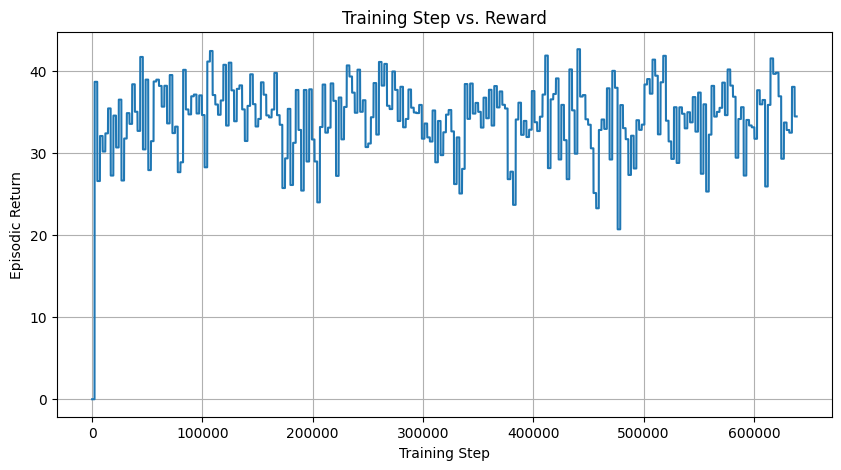

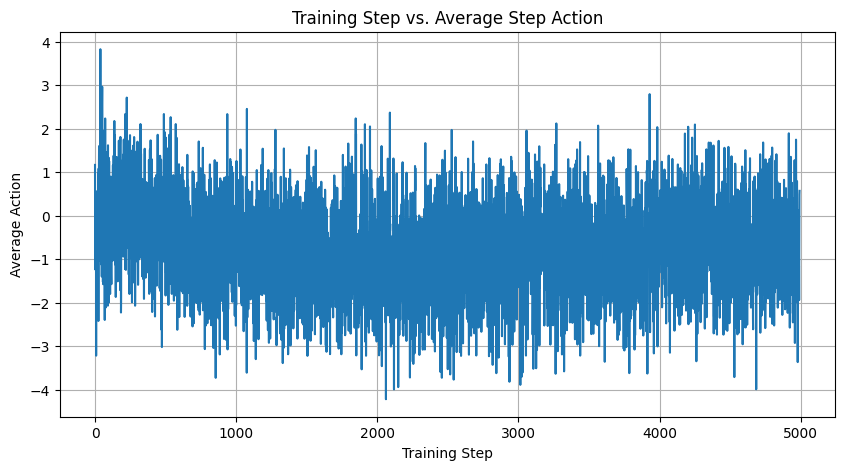

In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple
from flax.training.train_state import TrainState
import distrax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper
import matplotlib.pyplot as plt

# Assuming the 'chewc' library and custom wrappers are in the path
# from wrappers import VecEnv, NormalizeVecObservation, NormalizeVecReward, ClipAction
from chewc.gym import StoaEnv

class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh

        actor_mean = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        actor_logtstd = self.param("log_std", nn.initializers.zeros, (self.action_dim,))
        pi = distrax.MultivariateNormalDiag(actor_mean, jnp.exp(actor_logtstd))

        critic = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)

class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )

    # Use your custom environment
    env = StoaEnv()
    env_params = {} # Your environment doesn't have params

    # Add wrappers
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)
    # The following wrappers are commented out as they are not provided in the original script
    # env = ClipAction(env)
    # env = VecEnv(env)
    # if config["NORMALIZE_ENV"]:
    #     env = NormalizeVecObservation(env)
    #     env = NormalizeVecReward(env, config["GAMMA"])

    def linear_schedule(count):
        frac = (
            1.0
            - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"]))
            / config["NUM_UPDATES"]
        )
        return config["LR"] * frac

    def train(rng):
        # INIT NETWORK
        network = ActorCritic(
            env.action_space(env_params).shape[0], activation=config["ACTIVATION"]
        )
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                pi, value = network.apply(train_state.params, last_obs)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(env.step, in_axes=(0, 0, 0, None))(
                    rng_step, env_state, action, env_params
                )
                transition = Transition(
                    done, action, value, reward, log_prob, last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            _, last_val = network.apply(train_state.params, last_obs)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ENVS"]
                ), "batch size must be equal to number of steps * number of envs"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]

            # METRIC TRACKING
            avg_action_per_step = traj_batch.action.mean(axis=(1, 2)) # Mean over envs and action dim
            
            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, (metric, avg_action_per_step)

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, (metrics, avg_actions) = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metrics, "avg_actions": avg_actions}

    return train

def plot_results(metrics, avg_actions, config):
    # Extract rewards
    returned_episode_returns = metrics["returned_episode_returns"].flatten()
    
    # Create timesteps array
    timesteps = jnp.arange(len(returned_episode_returns)) * config["NUM_ENVS"] * config["NUM_STEPS"]

    # Plotting Training Step vs. Reward
    plt.figure(figsize=(10, 5))
    plt.plot(timesteps, returned_episode_returns)
    plt.xlabel("Training Step")
    plt.ylabel("Episodic Return")
    plt.title("Training Step vs. Reward")
    plt.grid(True)
    plt.show()

    # Reshape avg_actions for plotting
    avg_actions_flat = avg_actions.flatten()
    action_timesteps = jnp.arange(len(avg_actions_flat)) * config["NUM_ENVS"]

    # Plotting Training Step vs. Average Step Action
    plt.figure(figsize=(10, 5))
    plt.plot(action_timesteps, avg_actions_flat)
    plt.xlabel("Training Step")
    plt.ylabel("Average Action")
    plt.title("Training Step vs. Average Step Action")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    config = {
        "LR": 3e-4,
        "NUM_ENVS": 1,
        "NUM_STEPS": 128,
        "TOTAL_TIMESTEPS": 5e3,
        "UPDATE_EPOCHS": 4,
        "NUM_MINIBATCHES": 4,
        "GAMMA": 0.99,
        "GAE_LAMBDA": 0.95,
        "CLIP_EPS": 0.2,
        "ENT_COEF": 0.01,
        "VF_COEF": 0.5,
        "MAX_GRAD_NORM": 0.5,
        "ACTIVATION": "tanh",
        "ANNEAL_LR": True,
        "NORMALIZE_ENV": False, # Set to False as wrappers are not available
    }
    rng = jax.random.PRNGKey(42)
    
    # JIT compile the training function
    train_jit = jax.jit(make_train(config))
    
    # Run the training
    print("Starting training...")
    out = train_jit(rng)
    print("Training finished.")

    # Improved Logging
    print("\n--- Training Progress ---")
    num_updates = out["metrics"]["returned_episode_returns"].shape[0]
    for update in range(num_updates):
        start_step = update * config["NUM_STEPS"] * config["NUM_ENVS"]
        end_step = (update + 1) * config["NUM_STEPS"] * config["NUM_ENVS"]
        
        # Get rewards for the current update
        rewards = out["metrics"]["returned_episode_returns"][update].flatten()
        non_zero_rewards = rewards[rewards != 0]
        
        if non_zero_rewards.size > 0:
            avg_reward = non_zero_rewards.mean()
            print(f"Update {update+1}/{num_updates} (Steps: {start_step}-{end_step}): Average Episodic Return = {avg_reward:.2f}")

    # Visualization
    print("\nGenerating plots...")
    plot_results(out["metrics"], out["avg_actions"], config)

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import Tuple
from jax.tree_util import tree_map

# Assuming 'chewc' is installed or in the python path
# You might need to run: pip install git+https://github.com/deanm20/chewc.git
# Or adjust the imports if your file structure is different.
from chewc.structs import Population, BreedingState, Trait, GeneticMap, quick_haplo, add_trait
from chewc.pheno import calculate_phenotypes
from chewc.cross import random_mating, cross_pair


def run_baseline_episode(key: jax.Array, env: StoaEnv, constant_action: float) -> float:
    """
    Runs a single episode of the environment with a constant action.
    
    Args:
        key: JAX random key.
        env: An instance of the StoaEnv.
        constant_action: A float value between -1.0 and 1.0 to be used for every step.
        
    Returns:
        The final reward for the episode.
    """
    action_array = jnp.array([constant_action])
    
    # Reset the environment to get the initial state
    reset_key, loop_key = jax.random.split(key)
    _obs, state = env.reset(reset_key, env.default_params)
    
    def body_fun(i, val):
        # Unpack the loop state
        current_state, current_key = val
        # Get a new key for the step
        step_key, next_key = jax.random.split(current_key)
        # Take a step in the environment with the constant action
        _obs, next_state, reward, _done, _info = env.step(
            step_key, current_state, action_array, env.default_params
        )
        return (next_state, next_key)

    # The environment starts at generation 1 and the episode ends when generation >= total_gen.
    # This means we need to take `total_gen - 1` steps.
    num_steps = env.total_gen - 1
    final_state, _ = jax.lax.fori_loop(0, num_steps, body_fun, (state, loop_key))
    
    # After the loop, calculate the final reward from the terminal state
    # This is equivalent to the reward given on the last step
    reward_key, _ = jax.random.split(final_state.key)
    _, tbvs = calculate_phenotypes(
        reward_key, final_state.population, env.trait_architecture, env.heritabilities
    )
    final_reward = jnp.mean(tbvs[:, 0])
    
    return final_reward

# JIT-compile the function for a massive speedup
run_baseline_episode_jit = jax.jit(run_baseline_episode, static_argnums=(1,))


Running baseline evaluation for different constant actions...
Action: -1.00 (Select ~5%) -> Final Reward: 52.7518
Action: -0.80 (Select ~14%) -> Final Reward: 52.7518
Action: -0.60 (Select ~23%) -> Final Reward: 52.7518
Action: -0.40 (Select ~32%) -> Final Reward: 58.2958
Action: -0.20 (Select ~41%) -> Final Reward: 49.6600
Action: 0.00 (Select ~50%) -> Final Reward: 51.4469
Action: 0.20 (Select ~59%) -> Final Reward: 51.4469
Action: 0.40 (Select ~68%) -> Final Reward: 36.5270
Action: 0.60 (Select ~77%) -> Final Reward: 37.0550
Action: 0.80 (Select ~86%) -> Final Reward: 40.6469
Action: 1.00 (Select ~95%) -> Final Reward: 24.1042


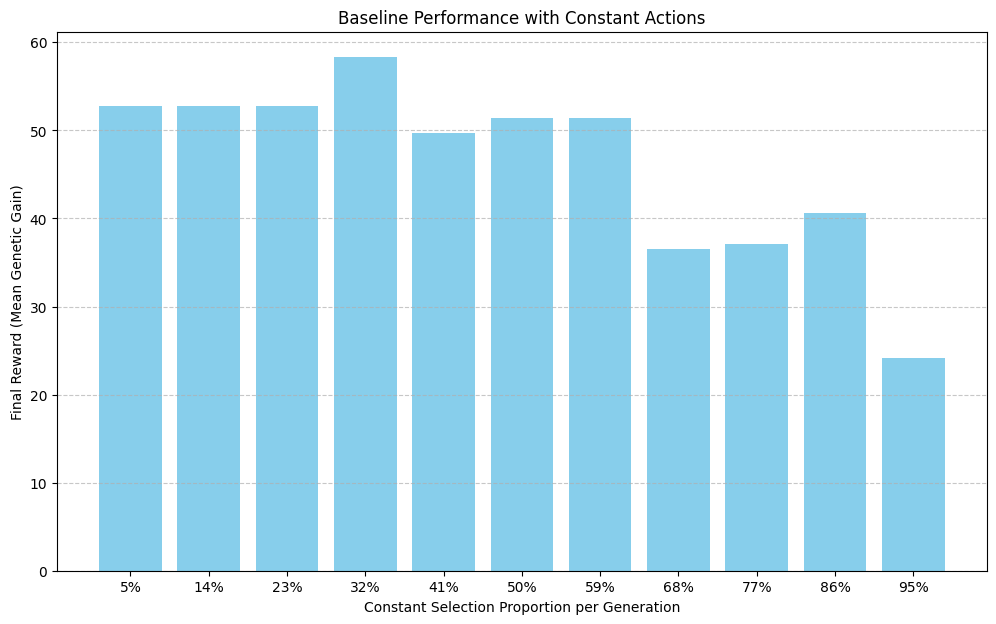

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import Tuple
from jax.tree_util import tree_map

# Assuming 'chewc' is installed or in the python path
from chewc.structs import Population, BreedingState, Trait, GeneticMap, quick_haplo, add_trait
from chewc.pheno import calculate_phenotypes
from chewc.cross import random_mating, cross_pair

# Import necessary gymnax components
from gymnax.environments import environment, spaces

# --- Environment Definition (Copied from your prompt) ---
class StoaEnv(environment.Environment):
    """
    A Gymnax environment for the ChewC breeding simulation.
    """
    def __init__(self, n_founders=10, n_pop_size=200, n_chr=5, n_loci=1000, n_qtl_per_chr=50, total_gen=5, max_crossovers=10):
        super().__init__()
        self.n_founders = n_founders
        self.n_pop_size = n_pop_size
        self.total_gen = total_gen
        self.max_crossovers = max_crossovers
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.n_qtl_per_chr = n_qtl_per_chr
        
        key = jax.random.PRNGKey(42)
        pop_key, trait_key = jax.random.split(key)

        self.founder_pop, self.genetic_map = quick_haplo(
            key=pop_key, n_ind=self.n_founders, n_chr=self.n_chr, seg_sites=self.n_loci
        )

        self.trait_architecture = add_trait(
            key=trait_key,
            founder_pop=self.founder_pop,
            n_qtl_per_chr=self.n_qtl_per_chr,
            mean=jnp.array([100.0]),
            var_a=jnp.array([10.0]),
            var_d=jnp.array([0.0]),
            sigma=jnp.array([[1.0]])
        )
        self.heritabilities = jnp.array([0.5])

    @property
    def default_params(self):
        return {}

    def step_env(self, key: jax.Array, state: BreedingState, action: jax.Array, params) -> Tuple[jax.Array, BreedingState, float, bool, dict]:
        key, pheno_key, mating_key, cross_key = jax.random.split(key, 4)
        current_pop = state.population
        
        selection_proportion = (action[0] + 1) / 2 * (0.95 - 0.05) + 0.05
        
        phenotypes, _ = calculate_phenotypes(
            key=pheno_key,
            population=current_pop,
            trait=self.trait_architecture,
            heritability=self.heritabilities
        )
        
        n_current_pop = current_pop.geno.shape[0]
        n_select = (n_current_pop * selection_proportion).astype(jnp.int32)
        n_select = jnp.maximum(2, n_select)
        
        sorted_indices = jnp.argsort(-phenotypes[:, 0].flatten())
        sorted_parent_pool = tree_map(lambda x: x[sorted_indices], current_pop)

        pairings = random_mating(mating_key, n_parents=n_select, n_crosses=self.n_pop_size)
        mother_indices, father_indices = pairings[:, 0], pairings[:, 1]
        
        mothers_geno = sorted_parent_pool.geno[mother_indices]
        fathers_geno = sorted_parent_pool.geno[father_indices]
        mothers_ibd = sorted_parent_pool.ibd[mother_indices]
        fathers_ibd = sorted_parent_pool.ibd[father_indices]
        
        vmapped_cross = jax.vmap(cross_pair, in_axes=(0, 0, 0, 0, 0, None, None))
        offspring_keys = jax.random.split(cross_key, self.n_pop_size)
        offspring_geno, offspring_ibd = vmapped_cross(
            offspring_keys, mothers_geno, fathers_geno, mothers_ibd, fathers_ibd, self.genetic_map, self.max_crossovers
        )
        
        new_generation = state.generation + 1
        new_ids = jnp.arange(self.n_pop_size, dtype=jnp.int32) + state.next_id
        new_meta = jnp.stack([
            new_ids,
            sorted_parent_pool.meta[mother_indices, 0],
            sorted_parent_pool.meta[father_indices, 0],
            jnp.full((self.n_pop_size,), new_generation, dtype=jnp.int32),
        ], axis=-1)
        
        new_population = Population(geno=offspring_geno, ibd=offspring_ibd, meta=new_meta)
        
        next_state = BreedingState(
            population=new_population, key=key, generation=new_generation, next_id=state.next_id + self.n_pop_size
        )
        
        done = next_state.generation >= self.total_gen

        def get_final_reward(final_state: BreedingState):
            reward_key, _ = jax.random.split(final_state.key)
            _, tbvs = calculate_phenotypes(
                reward_key, final_state.population, self.trait_architecture, self.heritabilities
            )
            return jnp.mean(tbvs[:, 0])

        reward = jax.lax.cond(done, get_final_reward, lambda s: 0.0, operand=next_state)
        
        obs = self._get_obs(next_state)
        return obs, next_state, reward, done, {}

    def reset_env(self, key: jax.Array, params) -> Tuple[jax.Array, BreedingState]:
        burn_in_key, pheno_key, mating_key, cross_key = jax.random.split(key, 4)
        founder_state = BreedingState(
            population=self.founder_pop, key=burn_in_key, generation=0, next_id=self.n_founders
        )
        
        phenotypes, _ = calculate_phenotypes(
            pheno_key, founder_state.population, self.trait_architecture, self.heritabilities
        )
        
        n_select = jnp.maximum(2, self.n_founders // 2)
        sorted_indices = jnp.argsort(-phenotypes[:, 0].flatten())
        sorted_founders = tree_map(lambda x: x[sorted_indices], founder_state.population)
        
        pairings = random_mating(mating_key, n_parents=n_select, n_crosses=self.n_pop_size)
        mother_indices, father_indices = pairings[:, 0], pairings[:, 1]
        
        mothers_geno = sorted_founders.geno[mother_indices]
        fathers_geno = sorted_founders.geno[father_indices]
        mothers_ibd = sorted_founders.ibd[mother_indices]
        fathers_ibd = sorted_founders.ibd[father_indices]

        vmapped_cross = jax.vmap(cross_pair, in_axes=(0, 0, 0, 0, 0, None, None))
        offspring_keys = jax.random.split(cross_key, self.n_pop_size)
        offspring_geno, offspring_ibd = vmapped_cross(
            offspring_keys, mothers_geno, fathers_geno, mothers_ibd, fathers_ibd, self.genetic_map, self.max_crossovers
        )
        
        initial_gen = 1
        initial_ids = jnp.arange(self.n_pop_size, dtype=jnp.int32) + founder_state.next_id
        initial_meta = jnp.stack([
            initial_ids,
            sorted_founders.meta[mother_indices, 0],
            sorted_founders.meta[father_indices, 0],
            jnp.full((self.n_pop_size,), initial_gen, dtype=jnp.int32),
        ], axis=-1)
        
        initial_pop = Population(geno=offspring_geno, ibd=offspring_ibd, meta=initial_meta)
        
        initial_state = BreedingState(
            population=initial_pop, key=key, generation=initial_gen, next_id=founder_state.next_id + self.n_pop_size
        )

        obs = self._get_obs(initial_state)
        return obs, initial_state

    def _get_obs(self, state: BreedingState) -> jax.Array:
        remaining_gen = jnp.maximum(0.0, (self.total_gen - state.generation) / self.total_gen)
        pheno_key, _ = jax.random.split(state.key)
        phenotypes, _ = calculate_phenotypes(
            key=pheno_key, population=state.population, trait=self.trait_architecture, heritability=self.heritabilities
        )
        pheno_trait_1 = phenotypes[:, 0]
        genetic_mean = jnp.mean(pheno_trait_1)
        genetic_var = jnp.var(pheno_trait_1)
        return jnp.array([remaining_gen, genetic_mean, genetic_var])

    def observation_space(self, params):
        low = jnp.array([0.0, -jnp.inf, 0.0], dtype=jnp.float32)
        high = jnp.array([1.0, jnp.inf, jnp.inf], dtype=jnp.float32)
        return spaces.Box(low, high, (3,), dtype=jnp.float32)

    def action_space(self, params):
        return spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=jnp.float32)


# --- Baseline Runner (Corrected) ---

def run_baseline_episode(key: jax.Array, env: StoaEnv, constant_action: float) -> float:
    """
    Runs a single episode of the environment with a constant action.
    """
    action_array = jnp.array([constant_action])
    
    reset_key, loop_key = jax.random.split(key)
    _obs, state = env.reset(reset_key, env.default_params)
    
    # --- The Fix is Here ---
    # We now carry the accumulated reward through the loop state.
    def body_fun(i, val):
        current_state, current_key, total_reward = val
        step_key, next_key = jax.random.split(current_key)
        
        _obs, next_state, reward, _done, _info = env.step(
            step_key, current_state, action_array, env.default_params
        )
        # Accumulate the reward from the step
        total_reward += reward
        return (next_state, next_key, total_reward)

    # The initial value for the loop now includes the reward, starting at 0.0
    initial_val = (state, loop_key, 0.0)
    
    # The number of steps is total_gen - 1 because the env starts at gen 1
    num_steps = env.total_gen - 1
    
    # The loop returns the final state, final key, and the final accumulated reward
    _final_state, _, final_reward = jax.lax.fori_loop(0, num_steps, body_fun, initial_val)
    
    return final_reward

# JIT-compile the corrected function
run_baseline_episode_jit = jax.jit(run_baseline_episode, static_argnums=(1,))


# --- Main Execution ---

if __name__ == "__main__":
    env = StoaEnv(n_founders=2, n_pop_size=10, n_loci=100, n_qtl_per_chr=50, total_gen=20)
    
    constant_actions_to_test = jnp.linspace(-1.0, 1.0, 11)
    baseline_results = []

    print("Running baseline evaluation for different constant actions...")
    
    for action_val in constant_actions_to_test:
        key = jax.random.PRNGKey(0)
        
        final_reward = run_baseline_episode_jit(key, env, action_val)
        baseline_results.append(final_reward)
        
        selection_prop = (action_val + 1) / 2 * (0.95 - 0.05) + 0.05
        print(f"Action: {action_val:.2f} (Select ~{selection_prop:.0%}) -> Final Reward: {final_reward:.4f}")

    # Visualize the results
    plt.figure(figsize=(12, 7))
    
    selection_proportions = (constant_actions_to_test + 1) / 2 * (0.95 - 0.05) + 0.05
    bar_labels = [f"{p:.0%}" for p in selection_proportions]
    
    plt.bar(bar_labels, baseline_results, color='skyblue')
    plt.xlabel("Constant Selection Proportion per Generation")
    plt.ylabel("Final Reward (Mean Genetic Gain)")
    plt.title("Baseline Performance with Constant Actions")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Running baseline evaluation (20 reps per action)...
Action: -1.00 (Select ~5%) -> Mean Reward: 42.3103 +/- 4.4938
Action: -0.89 (Select ~10%) -> Mean Reward: 44.1524 +/- 4.3547
Action: -0.79 (Select ~14%) -> Mean Reward: 42.2060 +/- 5.1471
Action: -0.68 (Select ~19%) -> Mean Reward: 43.0234 +/- 4.1763
Action: -0.58 (Select ~24%) -> Mean Reward: 43.7086 +/- 5.4349
Action: -0.47 (Select ~29%) -> Mean Reward: 42.4638 +/- 6.6613
Action: -0.37 (Select ~33%) -> Mean Reward: 40.0098 +/- 5.1512
Action: -0.26 (Select ~38%) -> Mean Reward: 39.8455 +/- 4.8990
Action: -0.16 (Select ~43%) -> Mean Reward: 36.5804 +/- 6.2051
Action: -0.05 (Select ~48%) -> Mean Reward: 35.4801 +/- 4.5529
Action: 0.05 (Select ~52%) -> Mean Reward: 31.5049 +/- 6.5163
Action: 0.16 (Select ~57%) -> Mean Reward: 33.2733 +/- 4.9051
Action: 0.26 (Select ~62%) -> Mean Reward: 28.3768 +/- 4.4683
Action: 0.37 (Select ~67%) -> Mean Reward: 31.0169 +/- 4.9088
Action: 0.47 (Select ~71%) -> Mean Reward: 25.5964 +/- 6.1986
Action: 0

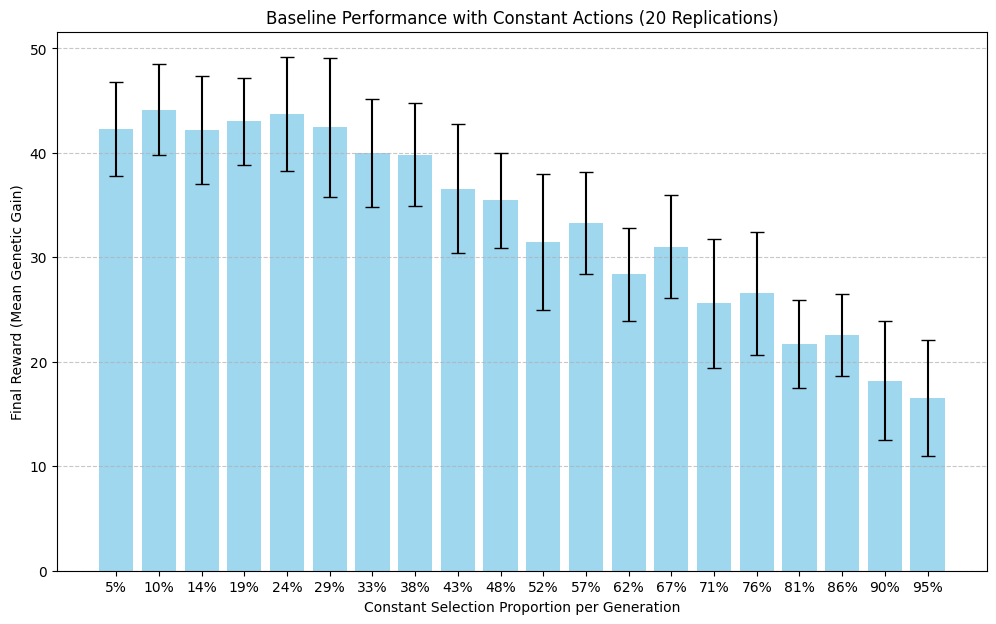

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import Tuple
from jax.tree_util import tree_map

# Assuming 'chewc' is installed or in the python path
from chewc.structs import Population, BreedingState, Trait, GeneticMap, quick_haplo, add_trait
from chewc.pheno import calculate_phenotypes
from chewc.cross import random_mating, cross_pair

# Import necessary gymnax components
from gymnax.environments import environment, spaces

# --- Environment Definition (Remains the same) ---
class StoaEnv(environment.Environment):
    """
    A Gymnax environment for the ChewC breeding simulation.
    """
    def __init__(self, n_founders=10, n_pop_size=200, n_chr=5, n_loci=1000, n_qtl_per_chr=50, total_gen=5, max_crossovers=10):
        super().__init__()
        self.n_founders = n_founders
        self.n_pop_size = n_pop_size
        self.total_gen = total_gen
        self.max_crossovers = max_crossovers
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.n_qtl_per_chr = n_qtl_per_chr
        
        key = jax.random.PRNGKey(42)
        pop_key, trait_key = jax.random.split(key)

        self.founder_pop, self.genetic_map = quick_haplo(
            key=pop_key, n_ind=self.n_founders, n_chr=self.n_chr, seg_sites=self.n_loci
        )

        self.trait_architecture = add_trait(
            key=trait_key,
            founder_pop=self.founder_pop,
            n_qtl_per_chr=self.n_qtl_per_chr,
            mean=jnp.array([0.0]),
            var_a=jnp.array([1.0]),
            var_d=jnp.array([0.0]),
            sigma=jnp.array([[1.0]])
        )
        self.heritabilities = jnp.array([1.0])

    @property
    def default_params(self):
        return {}

    def step_env(self, key: jax.Array, state: BreedingState, action: jax.Array, params) -> Tuple[jax.Array, BreedingState, float, bool, dict]:
        key, pheno_key, mating_key, cross_key = jax.random.split(key, 4)
        current_pop = state.population
        
        selection_proportion = (action[0] + 1) / 2 * (0.95 - 0.05) + 0.05
        
        phenotypes, _ = calculate_phenotypes(
            key=pheno_key,
            population=current_pop,
            trait=self.trait_architecture,
            heritability=self.heritabilities
        )
        
        n_current_pop = current_pop.geno.shape[0]
        n_select = (n_current_pop * selection_proportion).astype(jnp.int32)
        n_select = jnp.maximum(2, n_select)
        
        sorted_indices = jnp.argsort(-phenotypes[:, 0].flatten())
        sorted_parent_pool = tree_map(lambda x: x[sorted_indices], current_pop)

        pairings = random_mating(mating_key, n_parents=n_select, n_crosses=self.n_pop_size)
        mother_indices, father_indices = pairings[:, 0], pairings[:, 1]
        
        mothers_geno = sorted_parent_pool.geno[mother_indices]
        fathers_geno = sorted_parent_pool.geno[father_indices]
        mothers_ibd = sorted_parent_pool.ibd[mother_indices]
        fathers_ibd = sorted_parent_pool.ibd[father_indices]
        
        vmapped_cross = jax.vmap(cross_pair, in_axes=(0, 0, 0, 0, 0, None, None))
        offspring_keys = jax.random.split(cross_key, self.n_pop_size)
        offspring_geno, offspring_ibd = vmapped_cross(
            offspring_keys, mothers_geno, fathers_geno, mothers_ibd, fathers_ibd, self.genetic_map, self.max_crossovers
        )
        
        new_generation = state.generation + 1
        new_ids = jnp.arange(self.n_pop_size, dtype=jnp.int32) + state.next_id
        new_meta = jnp.stack([
            new_ids,
            sorted_parent_pool.meta[mother_indices, 0],
            sorted_parent_pool.meta[father_indices, 0],
            jnp.full((self.n_pop_size,), new_generation, dtype=jnp.int32),
        ], axis=-1)
        
        new_population = Population(geno=offspring_geno, ibd=offspring_ibd, meta=new_meta)
        
        next_state = BreedingState(
            population=new_population, key=key, generation=new_generation, next_id=state.next_id + self.n_pop_size
        )
        
        done = next_state.generation >= self.total_gen

        def get_final_reward(final_state: BreedingState):
            reward_key, _ = jax.random.split(final_state.key)
            _, tbvs = calculate_phenotypes(
                reward_key, final_state.population, self.trait_architecture, self.heritabilities
            )
            return jnp.mean(tbvs[:, 0])

        reward = jax.lax.cond(done, get_final_reward, lambda s: 0.0, operand=next_state)
        
        obs = self._get_obs(next_state)
        return obs, next_state, reward, done, {}

    def reset_env(self, key: jax.Array, params) -> Tuple[jax.Array, BreedingState]:
        burn_in_key, pheno_key, mating_key, cross_key = jax.random.split(key, 4)
        founder_state = BreedingState(
            population=self.founder_pop, key=burn_in_key, generation=0, next_id=self.n_founders
        )
        
        phenotypes, _ = calculate_phenotypes(
            pheno_key, founder_state.population, self.trait_architecture, self.heritabilities
        )
        
        n_select = jnp.maximum(2, self.n_founders // 2)
        sorted_indices = jnp.argsort(-phenotypes[:, 0].flatten())
        sorted_founders = tree_map(lambda x: x[sorted_indices], founder_state.population)
        
        pairings = random_mating(mating_key, n_parents=n_select, n_crosses=self.n_pop_size)
        mother_indices, father_indices = pairings[:, 0], pairings[:, 1]
        
        mothers_geno = sorted_founders.geno[mother_indices]
        fathers_geno = sorted_founders.geno[father_indices]
        mothers_ibd = sorted_founders.ibd[mother_indices]
        fathers_ibd = sorted_founders.ibd[father_indices]

        vmapped_cross = jax.vmap(cross_pair, in_axes=(0, 0, 0, 0, 0, None, None))
        offspring_keys = jax.random.split(cross_key, self.n_pop_size)
        offspring_geno, offspring_ibd = vmapped_cross(
            offspring_keys, mothers_geno, fathers_geno, mothers_ibd, fathers_ibd, self.genetic_map, self.max_crossovers
        )
        
        initial_gen = 1
        initial_ids = jnp.arange(self.n_pop_size, dtype=jnp.int32) + founder_state.next_id
        initial_meta = jnp.stack([
            initial_ids,
            sorted_founders.meta[mother_indices, 0],
            sorted_founders.meta[father_indices, 0],
            jnp.full((self.n_pop_size,), initial_gen, dtype=jnp.int32),
        ], axis=-1)
        
        initial_pop = Population(geno=offspring_geno, ibd=offspring_ibd, meta=initial_meta)
        
        initial_state = BreedingState(
            population=initial_pop, key=key, generation=initial_gen, next_id=founder_state.next_id + self.n_pop_size
        )

        obs = self._get_obs(initial_state)
        return obs, initial_state

    def _get_obs(self, state: BreedingState) -> jax.Array:
        remaining_gen = jnp.maximum(0.0, (self.total_gen - state.generation) / self.total_gen)
        pheno_key, _ = jax.random.split(state.key)
        phenotypes, _ = calculate_phenotypes(
            key=pheno_key, population=state.population, trait=self.trait_architecture, heritability=self.heritabilities
        )
        pheno_trait_1 = phenotypes[:, 0]
        genetic_mean = jnp.mean(pheno_trait_1)
        genetic_var = jnp.var(pheno_trait_1)
        return jnp.array([remaining_gen, genetic_mean, genetic_var])

    def observation_space(self, params):
        low = jnp.array([0.0, -jnp.inf, 0.0], dtype=jnp.float32)
        high = jnp.array([1.0, jnp.inf, jnp.inf], dtype=jnp.float32)
        return spaces.Box(low, high, (3,), dtype=jnp.float32)

    def action_space(self, params):
        return spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=jnp.float32)


# --- Baseline Runner (Single Episode) ---
# This function remains the same, as it's the one we will vectorize.
def run_baseline_episode(key: jax.Array, env: StoaEnv, constant_action: float) -> float:
    action_array = jnp.array([constant_action])
    reset_key, loop_key = jax.random.split(key)
    _obs, state = env.reset(reset_key, env.default_params)
    
    def body_fun(i, val):
        current_state, current_key, total_reward = val
        step_key, next_key = jax.random.split(current_key)
        _obs, next_state, reward, _done, _info = env.step(
            step_key, current_state, action_array, env.default_params
        )
        total_reward += reward
        return (next_state, next_key, total_reward)

    initial_val = (state, loop_key, 0.0)
    num_steps = env.total_gen - 1
    _final_state, _, final_reward = jax.lax.fori_loop(0, num_steps, body_fun, initial_val)
    
    return final_reward

# --- Vectorized Runner for Replications ---
# We use jax.vmap to run multiple episodes in parallel.
# We map over the first argument (the key) but keep the env and action constant for each batch.
run_replicated_baseline_jit = jax.jit(
    jax.vmap(run_baseline_episode, in_axes=(0, None, None)), 
    static_argnums=(1,)
)


# --- Main Execution ---
if __name__ == "__main__":
    # Number of replications to run for each action
    N_REPS = 20
    
    env = StoaEnv(n_founders=2, n_pop_size=10, n_loci=100, n_qtl_per_chr=5, total_gen=5)
    
    constant_actions_to_test = jnp.linspace(-1.0, 1.0, 20)
    baseline_means = []
    baseline_stds = []

    # A single base key for the entire experiment
    base_key = jax.random.PRNGKey(0)

    print(f"Running baseline evaluation ({N_REPS} reps per action)...")
    
    for action_val in constant_actions_to_test:
        # Generate a unique set of keys for this action's replications
        base_key, rep_key = jax.random.split(base_key)
        replication_keys = jax.random.split(rep_key, N_REPS)
        
        # Run all replications in parallel
        rewards = run_replicated_baseline_jit(replication_keys, env, action_val)
        
        # Calculate and store statistics
        mean_reward = rewards.mean()
        std_reward = rewards.std()
        baseline_means.append(mean_reward)
        baseline_stds.append(std_reward)
        
        selection_prop = (action_val + 1) / 2 * (0.95 - 0.05) + 0.05
        print(f"Action: {action_val:.2f} (Select ~{selection_prop:.0%}) -> Mean Reward: {mean_reward:.4f} +/- {std_reward:.4f}")

    # Visualize the results with error bars
    plt.figure(figsize=(12, 7))
    
    selection_proportions = (constant_actions_to_test + 1) / 2 * (0.95 - 0.05) + 0.05
    bar_labels = [f"{p:.0%}" for p in selection_proportions]
    
    plt.bar(bar_labels, baseline_means, yerr=baseline_stds, color='skyblue', capsize=5, alpha=0.8)
    
    plt.xlabel("Constant Selection Proportion per Generation")
    plt.ylabel("Final Reward (Mean Genetic Gain)")
    plt.title(f"Baseline Performance with Constant Actions ({N_REPS} Replications)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [ ]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Tuple, Optional
from flax.training.train_state import TrainState
import distrax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper
import matplotlib.pyplot as plt
from functools import partial
from jax.tree_util import tree_map

# Assuming the 'chewc' library files are in the path
# Note: The following imports assume 'chewc' is an installed package.
# If you are running from within the package, you might need to adjust them.
from chewc.structs import Population, BreedingState, Trait, GeneticMap, quick_haplo, add_trait
from chewc.pheno import calculate_phenotypes
from chewc.cross import random_mating, cross_pair
from gymnax.environments import environment, spaces


class StoaEnv(environment.Environment):
    """
    A Gymnax environment for the ChewC breeding simulation.

    The agent's goal is to maximize the genetic gain of the population
    over a fixed number of generations by choosing the selection intensity at each step.
    """

    def __init__(self, n_founders=10, n_pop_size=200, n_chr=5, n_loci=1000, n_qtl_per_chr=50, total_gen=5, max_crossovers=10):
        super().__init__()
        self.n_founders = n_founders
        self.n_pop_size = n_pop_size
        self.total_gen = total_gen
        self.max_crossovers = max_crossovers
        self.n_chr = n_chr
        self.n_loci = n_loci
        self.n_qtl_per_chr = n_qtl_per_chr

        key = jax.random.PRNGKey(42)
        pop_key, trait_key = jax.random.split(key)

        # Founder pop is created once and reused for every reset
        self.founder_pop, self.genetic_map = quick_haplo(
            key=pop_key, n_ind=self.n_founders, n_chr=self.n_chr, seg_sites=self.n_loci
        )

        self.trait_architecture = add_trait(
            key=trait_key,
            founder_pop=self.founder_pop,
            n_qtl_per_chr=self.n_qtl_per_chr,
            mean=jnp.array([100.0]),
            var_a=jnp.array([10.0]),
            var_d=jnp.array([0.0]),
            sigma=jnp.array([[1.0]])
        )
        self.heritabilities = jnp.array([0.5])

    @property
    def default_params(self):
        return {}

    def step_env(self, key: jax.Array, state: BreedingState, action: jax.Array, params) -> Tuple[jax.Array, BreedingState, float, bool, dict]:
        key, pheno_key, mating_key, cross_key = jax.random.split(key, 4)
        current_pop = state.population

        selection_proportion = (action[0] + 1) / 2 * (0.95 - 0.05) + 0.05

        phenotypes, _ = calculate_phenotypes(
            key=pheno_key,
            population=current_pop,
            trait=self.trait_architecture,
            heritability=self.heritabilities
        )

        n_current_pop = current_pop.geno.shape[0]
        n_select = (n_current_pop * selection_proportion).astype(jnp.int32)
        n_select = jnp.maximum(2, n_select)

        sorted_indices = jnp.argsort(-phenotypes[:, 0].flatten())
        sorted_parent_pool = tree_map(lambda x: x[sorted_indices], current_pop)

        pairings = random_mating(mating_key, n_parents=n_select, n_crosses=self.n_pop_size)
        mother_indices, father_indices = pairings[:, 0], pairings[:, 1]

        mothers_geno = sorted_parent_pool.geno[mother_indices]
        fathers_geno = sorted_parent_pool.geno[father_indices]
        mothers_ibd = sorted_parent_pool.ibd[mother_indices]
        fathers_ibd = sorted_parent_pool.ibd[father_indices]

        vmapped_cross = jax.vmap(cross_pair, in_axes=(0, 0, 0, 0, 0, None, None))
        offspring_keys = jax.random.split(cross_key, self.n_pop_size)
        offspring_geno, offspring_ibd = vmapped_cross(
            offspring_keys, mothers_geno, fathers_geno, mothers_ibd, fathers_ibd, self.genetic_map, self.max_crossovers
        )

        new_generation = state.generation + 1
        new_ids = jnp.arange(self.n_pop_size, dtype=jnp.int32) + state.next_id
        new_meta = jnp.stack([
            new_ids,
            sorted_parent_pool.meta[mother_indices, 0],
            sorted_parent_pool.meta[father_indices, 0],
            jnp.full((self.n_pop_size,), new_generation, dtype=jnp.int32),
        ], axis=-1)

        new_population = Population(geno=offspring_geno, ibd=offspring_ibd, meta=new_meta)

        next_state = BreedingState(
            population=new_population, key=key, generation=new_generation, next_id=state.next_id + self.n_pop_size
        )

        done = next_state.generation >= self.total_gen

        def get_final_reward(final_state: BreedingState):
            reward_key, _ = jax.random.split(final_state.key)
            _, tbvs = calculate_phenotypes(
                reward_key, final_state.population, self.trait_architecture, self.heritabilities
            )
            return jnp.mean(tbvs[:, 0])

        reward = jax.lax.cond(done, get_final_reward, lambda s: 0.0, operand=next_state)

        obs = self._get_obs(next_state)
        return obs, next_state, reward, done, {}

    def reset_env(self, key: jax.Array, params) -> Tuple[jax.Array, BreedingState]:
        """
        Resets the environment. Includes a "burn-in" step to ensure the
        initial population size matches the ongoing population size, which is
        required for JAX's conditional logic in auto-resetting environments.
        """
        burn_in_key, pheno_key, mating_key, cross_key = jax.random.split(key, 4)
        founder_state = BreedingState(
            population=self.founder_pop, key=burn_in_key, generation=0, next_id=self.n_founders
        )

        phenotypes, _ = calculate_phenotypes(
            pheno_key, founder_state.population, self.trait_architecture, self.heritabilities
        )

        n_select = jnp.maximum(2, self.n_founders // 2)
        sorted_indices = jnp.argsort(-phenotypes[:, 0].flatten())
        sorted_founders = tree_map(lambda x: x[sorted_indices], founder_state.population)

        pairings = random_mating(mating_key, n_parents=n_select, n_crosses=self.n_pop_size)
        mother_indices, father_indices = pairings[:, 0], pairings[:, 1]

        mothers_geno = sorted_founders.geno[mother_indices]
        fathers_geno = sorted_founders.geno[father_indices]
        mothers_ibd = sorted_founders.ibd[mother_indices]
        fathers_ibd = sorted_founders.ibd[father_indices]

        vmapped_cross = jax.vmap(cross_pair, in_axes=(0, 0, 0, 0, 0, None, None))
        offspring_keys = jax.random.split(cross_key, self.n_pop_size)
        offspring_geno, offspring_ibd = vmapped_cross(
            offspring_keys, mothers_geno, fathers_geno, mothers_ibd, fathers_ibd, self.genetic_map, self.max_crossovers
        )

        initial_gen = 1
        initial_ids = jnp.arange(self.n_pop_size, dtype=jnp.int32) + founder_state.next_id
        initial_meta = jnp.stack([
            initial_ids,
            sorted_founders.meta[mother_indices, 0],
            sorted_founders.meta[father_indices, 0],
            jnp.full((self.n_pop_size,), initial_gen, dtype=jnp.int32),
        ], axis=-1)

        initial_pop = Population(geno=offspring_geno, ibd=offspring_ibd, meta=initial_meta)

        initial_state = BreedingState(
            population=initial_pop, key=key, generation=initial_gen, next_id=founder_state.next_id + self.n_pop_size
        )

        obs = self._get_obs(initial_state)
        return obs, initial_state

    def _get_obs(self, state: BreedingState) -> jax.Array:
        remaining_gen = jnp.maximum(0.0, (self.total_gen - state.generation) / self.total_gen)
        pheno_key, _ = jax.random.split(state.key)
        phenotypes, _ = calculate_phenotypes(
            key=pheno_key, population=state.population, trait=self.trait_architecture, heritability=self.heritabilities
        )
        pheno_trait_1 = phenotypes[:, 0]
        genetic_mean = jnp.mean(pheno_trait_1)
        genetic_var = jnp.var(pheno_trait_1)
        return jnp.array([remaining_gen, genetic_mean, genetic_var])

    def observation_space(self, params):
        low = jnp.array([0.0, -jnp.inf, 0.0], dtype=jnp.float32)
        high = jnp.array([1.0, jnp.inf, jnp.inf], dtype=jnp.float32)
        return spaces.Box(low, high, (3,), dtype=jnp.float32)

    def action_space(self, params):
        return spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=jnp.float32)


class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        actor_logtstd = self.param("log_std", nn.initializers.zeros, (self.action_dim,))
        pi = distrax.MultivariateNormalDiag(actor_mean, jnp.exp(actor_logtstd))

        critic = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)


class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray


def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )

    env = StoaEnv(total_gen=config["TOTAL_GEN"],n_founders=2, n_pop_size=100, n_loci=100, n_qtl_per_chr=50)
    env_params = env.default_params

    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)

    def linear_schedule(count):
        frac = (
            1.0
            - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"]))
            / config["NUM_UPDATES"]
        )
        return config["LR"] * frac

    def train(rng):
        # INIT NETWORK
        network = ActorCritic(
            env.action_space(env_params).shape[0], activation=config["ACTIVATION"]
        )
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros((config["NUM_ENVS"],) + env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                pi, value = network.apply(train_state.params, last_obs)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = jax.vmap(
                    env.step, in_axes=(0, 0, 0, None)
                )(rng_step, env_state, action, env_params)
                transition = Transition(
                    done, action, value, reward, log_prob, last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            _, last_val = network.apply(train_state.params, last_obs)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ENVS"]
                ), "batch size must be equal to number of steps * number of envs"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]

            # STORE THE AVERAGE ACTION FOR EACH STEP IN THE TRAJECTORY
            avg_action_per_step = traj_batch.action.mean(axis=1) # Average across environments

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, (metric, avg_action_per_step)

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, (metrics, avg_actions) = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metrics, "avg_actions": avg_actions}

    return train


def plot_results(metrics, avg_actions, config, rolling_window_size=50):
    """
    Generates and displays plots for training rewards and average actions.
    Introduces a rolling average and opacity for better legibility of the action plot.
    """

    # 1. PLOT FOR TRAINING STEP VS REWARD
    episodic_returns = metrics["returned_episode_returns"].flatten()
    valid_returns = episodic_returns[episodic_returns != 0]

    plt.figure(figsize=(10, 5))

    # Calculate and plot the rolling average for the reward
    if len(valid_returns) > rolling_window_size:
        # Calculate rolling average
        returns_rolling_avg = np.convolve(valid_returns, np.ones(rolling_window_size)/rolling_window_size, mode='valid')
        plt.plot(np.arange(len(valid_returns)), valid_returns, alpha=0.3, label='Episodic Return')
        plt.plot(np.arange(rolling_window_size - 1, len(valid_returns)), returns_rolling_avg, color='red', label=f'Rolling Avg (window={rolling_window_size})')
        plt.legend()
    else:
        plt.plot(valid_returns, label='Episodic Return')

    plt.xlabel("Training Episode")
    plt.ylabel("Episodic Return")
    plt.title("Episodic Return over Training")
    plt.grid(True)
    plt.show()

    # 2. PLOT FOR TRAINING STEP VS AVERAGE STEP ACTION
    avg_actions = jnp.squeeze(avg_actions, axis=-1)
    num_updates = avg_actions.shape[0]
    total_gen = config["TOTAL_GEN"]

    fig, ax = plt.subplots(figsize=(14, 8))
    updates_axis = np.arange(num_updates)

    # Use a sequential colormap to represent the progression of generations
    colors = plt.cm.viridis(np.linspace(0, 1, total_gen))

    # For each generation (step in episode), plot a separate smoothed line
    for g in range(total_gen):
        actions_for_this_gen = avg_actions[:, g::total_gen].mean(axis=1)

        # Calculate the rolling average to smooth the line
        if num_updates > rolling_window_size:
            smoothed_actions = np.convolve(actions_for_this_gen, np.ones(rolling_window_size)/rolling_window_size, mode='valid')
            # Adjust the x-axis for the smoothed data
            smoothed_updates_axis = updates_axis[rolling_window_size - 1:]
            ax.plot(smoothed_updates_axis, smoothed_actions, color=colors[g], alpha=0.7)
        else:
            # Plot raw data if there are not enough points for a rolling average
            ax.plot(updates_axis, actions_for_this_gen, color=colors[g], alpha=0.7)

    ax.set_xlabel("Training Update")
    ax.set_ylabel("Average Action")
    ax.set_title(f"Average Action per Generation (Rolling Average Window: {rolling_window_size})")
    ax.grid(True)

    # Add a colorbar instead of a crowded legend
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=1, vmax=total_gen))
    cbar = fig.colorbar(sm, ax=ax, ticks=np.linspace(1, total_gen, 10, dtype=int))
    cbar.set_label('Generation in Episode')

    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    config = {
        "LR": 3e-4,
        "NUM_ENVS": 1,
        "NUM_STEPS": 128,
        "TOTAL_TIMESTEPS": 5e3,
        "UPDATE_EPOCHS": 4,
        "NUM_MINIBATCHES": 32,
        "GAMMA": 0.99,
        "GAE_LAMBDA": 0.95,
        "CLIP_EPS": 0.2,
        "ENT_COEF": 0.01,
        "VF_COEF": 0.5,
        "MAX_GRAD_NORM": 0.5,
        "ACTIVATION": "tanh",
        "ANNEAL_LR": True,
        "TOTAL_GEN": 20, # Max generations per episode from StoaEnv
    }
    rng = jax.random.PRNGKey(42)

    train_fn = make_train(config)
    train_jit = jax.jit(train_fn)

    print("Starting training... (This may take a while)")
    out = train_jit(rng)
    print("Training finished.")

    # 1. IMPROVED LOGGING
    print("\n--- Training Summary ---")
    num_updates = out["metrics"]["returned_episode_returns"].shape[0]
    total_steps_per_update = config["NUM_STEPS"] * config["NUM_ENVS"]

    for update in range(num_updates):
        global_step = (update + 1) * total_steps_per_update

        # Get rewards for the current update, filter out non-terminal steps
        rewards = out["metrics"]["returned_episode_returns"][update].flatten()
        finished_episodes = rewards[rewards != 0]

        if finished_episodes.size > 0:
            avg_reward = finished_episodes.mean()
            print(f"Update {update+1}/{num_updates} (Step: {global_step}): Avg. Episodic Return = {avg_reward:.2f}")

    # 2. & 3. VISUALIZATION
    print("\nGenerating plots...")
    plot_results(out["metrics"], out["avg_actions"], config)

Starting training... (This may take a while)
Training finished.

--- Training Summary ---
